# TODO
- need all cells to make argument for SC vs BULK analysis

# Setup

In [1]:
wkdir, s3dir = '/home/ubuntu/data/DL20190312_dish_mel', 'daniel.le-work/dish_MEL'
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_all']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var


scanpy version: 1.3.3


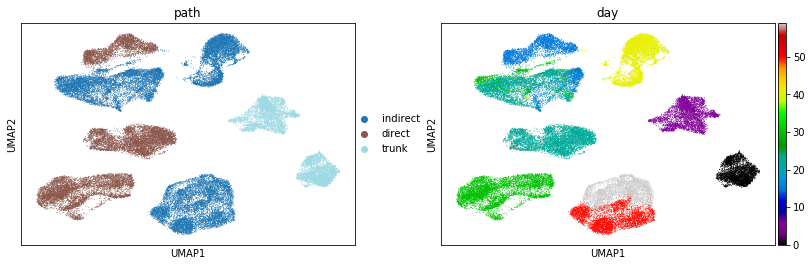

In [2]:
# sanity check
sc.pl.umap(adata_all, color = ['path', 'day'], palette = 'tab20', cmap = 'nipy_spectral')

In [3]:
# FUNCTIONS
from collections import defaultdict
import multiprocessing

def single_mwu(args):    
    # inputs
    gene_val, df1, df2, alt = args
    
    try:
        stat, pval = stats.mannwhitneyu(df1[gene_val].values,
                                        df2[gene_val].values, 
                                        alternative = alt
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

def parallel_mwu(genes, df1, df2, method='two-sided', ncores=1):
    
    p = multiprocessing.Pool(processes=ncores)
    try:
        mwu_tuples = p.map(single_mwu, 
                                zip(genes,
                                    [df1]*len(genes),
                                    [df2]*len(genes),
                                    [method]*len(genes)
                                   ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()

    stat_list = [x[0] for x in mwu_tuples]
    pval_list = [x[1] for x in mwu_tuples]
    return (stat_list, pval_list)

def disp_analysis(adata, min_mean=0.0125, max_mean=10, min_disp=0.1):
    
    print('Process expression data...')
    print('\tInitial:')
    sum_output(adata)
    
    tmp = sc.pp.normalize_per_cell(adata, copy=True)
    filter_result = sc.pp.filter_genes_dispersion(tmp.X, 
                                                  min_mean=min_mean, 
                                                  max_mean=max_mean, 
                                                  min_disp=min_disp)
    tmp = tmp[:, filter_result.gene_subset]
    
    print('Filtered cells: {}'.format(len(adata.obs) - len(tmp.obs)))
    print('Filtered genes: {}'.format(len(adata.var_names) - len(tmp.var_names)))
    print('\tResult:')
    sum_output (tmp)
    
    return tmp

# Ingest data

In [4]:
run_me = False

if run_me == True:

    ### TRUNK ###

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D0_COI.h5ad'
    adata_d0 = ad.read_h5ad(filename)

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D6_COI.h5ad'
    adata_d6 = ad.read_h5ad(filename)

    # merge trunk
    adata_trunk = adata_d0.concatenate(adata_d6, join='outer')

    # update meta data with path and day
    adata_trunk.obs['path'] = 'trunk'
    adata_trunk.obs['path'] = adata_trunk.obs['path'].astype(str).astype(CategoricalDtype(['trunk']))
    adata_trunk.obs['day'] = [int(x.split('d')[-1]) for x in adata_trunk.obs['sample']]

    # prune genes by dispersion
    adata_trunk = disp_analysis(adata_trunk)

    ### DIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_all_COI.h5ad'
    adata_dir = ad.read_h5ad(filename)

    # replacement d15
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_D15v2_COI.h5ad'
    adata_d15v2_dir = ad.read_h5ad(filename)

    # remove old d15 and replace with new
    adata_dir = adata_dir[adata_dir.obs['sample'] != 'd15_dir']
    adata_dir = adata_dir.concatenate(adata_d15v2_dir, join='outer')

    # update meta data with path and day
    adata_dir.obs['path'] = 'direct'
    adata_dir.obs['path'] = adata_dir.obs['path'].astype(str).astype(CategoricalDtype(['direct']))
    adata_dir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_dir.obs['sample']]

    # add trunk
    adata_full_dir = adata_dir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
    adata_full_dir = disp_analysis(adata_full_dir)

    ### INDIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_indir_all_COI.h5ad'
    adata_indir = ad.read_h5ad(filename)

    # update meta data with path and day
    adata_indir.obs['path'] = 'indirect'
    adata_indir.obs['path'] = adata_indir.obs['path'].astype(str).astype(CategoricalDtype(['indirect']))
    adata_indir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_indir.obs['sample']]

    # add trunk
    adata_full_indir = adata_indir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
    adata_full_indir = disp_analysis(adata_full_indir)

    ### ALL ###

    # merge all
    adata_all = adata_trunk.concatenate(adata_dir, adata_indir, join='outer')

    # prune genes by dispersion
    adata_all = disp_analysis(adata_all)

    # update meta data with path and day
    adata_all.obs['path'] = adata_all.obs['path'].astype(str).astype(CategoricalDtype(['indirect','direct','trunk']))

    # freeze raw counts and scale
    # adata_all.X = sparse.csr_matrix(np.round(np.exp(adata_all.X.toarray())) - 1, dtype = np.float64)
    adata_all.raw = adata_all
    # sc.pp.log1p(adata_all)
    sc.pp.scale(adata_all)

    # UMAP and PCA
    input_adata = adata_all
    pca_adata(input_adata, num_pcs=25)
    umap_adata(input_adata, res=0.15, scan = False)

    # pickle adatas
    for objname in ['adata_all']:
        pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
        syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
        subprocess.run(syscmd.split(' '))


# PCA

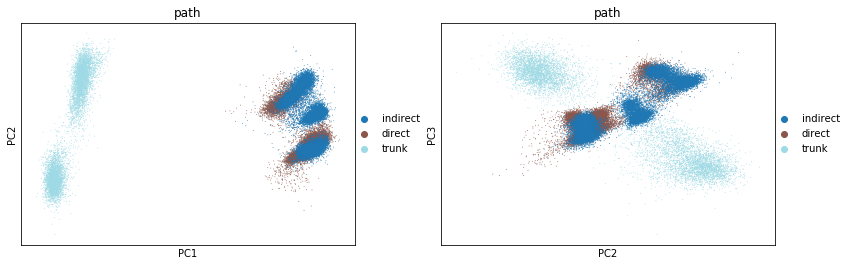

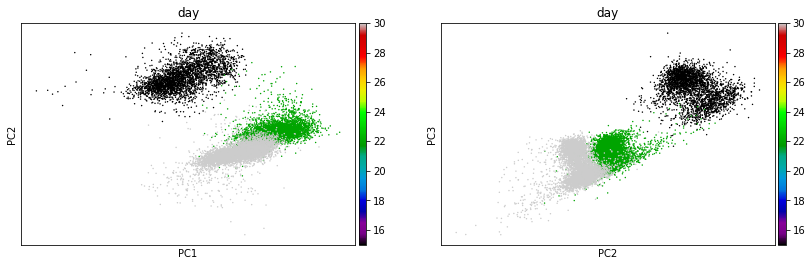

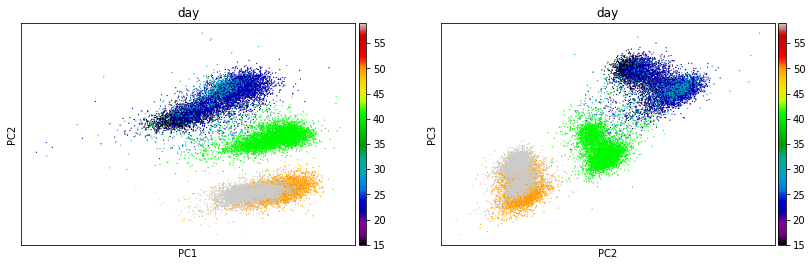

In [5]:
sc.pl.pca(adata_all, color = ['path'], components=['1,2','2,3'], palette = 'tab20')
sc.pl.pca(adata_all[adata_all.obs.path == 'direct'], color = ['day'], components=['1,2','2,3'], cmap = 'nipy_spectral')
sc.pl.pca(adata_all[adata_all.obs.path == 'indirect'], color = ['day'], components=['1,2','2,3'], cmap = 'nipy_spectral')




# terminally-differentiated DE

In [6]:
# genes expressed exclusively in dir or indir
# dir d30 vs indir d50/59
## MWU tests
#

adata_dir_d30 = adata_all[[x == 30 and y == 'direct' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
adata_indir_d50_59 = adata_all[[x >= 50 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_dir_d30.var_names) & set(adata_indir_d50_59.var_names))

cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                         genes,
                                        'path',
                                         use_raw = True)

# bulkized correlation
print(stats.spearmanr(adata_dir_d30_df.mean().values, adata_indir_d50_59_df.mean().values))

# mwu test: adt vs fet/neo
stat_pval_tuple = parallel_mwu(genes, 
                               adata_dir_d30_df.rank(pct=True, axis = 1, method = 'min'), 
                               adata_indir_d50_59_df.rank(pct=True, axis = 1, method = 'min'), 
                               'two-sided', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df1 = (pd.DataFrame({'gene':genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )


SpearmanrResult(correlation=0.9094070737686717, pvalue=0.0)


In [7]:
mwu_df1.dropna().sort_values('stat_1').head(20)

,gene,stat_1,pval_1
3956,MFSD12,2570237.0,0.0
338,FTL,3102940.5,0.0
5569,RPS10,4903508.0,0.0
5136,RPS27,5604911.5,0.0
2355,ATOX1,5651882.5,0.0
657,S100B,5881768.0,0.0
2635,RPLP2,5934570.5,0.0
5761,SNHG6,6264367.5,0.0
1427,LGALS3,6543147.5,0.0
1065,CALR,6877628.5,0.0


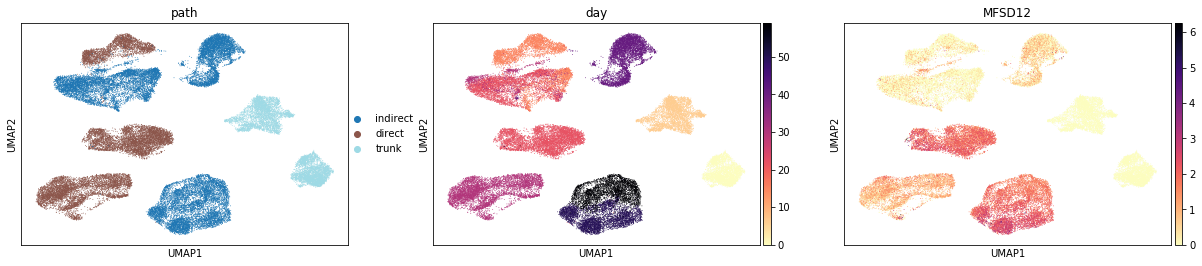

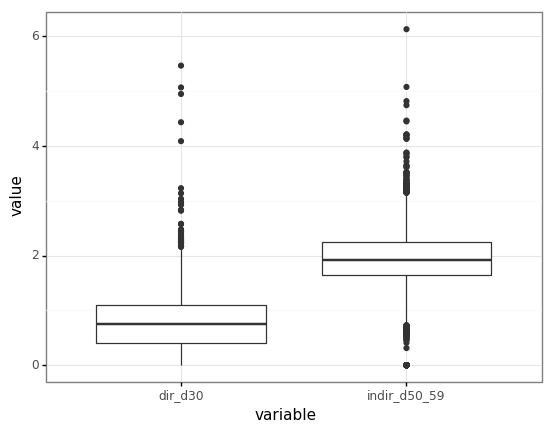

<ggplot: (-9223363285949684094)>
querying 1-1...done.
Finished.
0:  MFSD12 
 N/A


In [8]:
gene = 'MFSD12'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_dir_d30_df[gene].values,
                        'variable':'dir_d30'
                       }).append(pd.DataFrame({'value':adata_indir_d50_59_df[gene].values,
                                               'variable':'indir_d50_59'
                                              }))

print(ggplot(plot_df)
     + theme_bw()
     + geom_boxplot(aes('variable','value'))
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# d41 indirect DE

In [9]:
# determine DE unique indirect cluster

adata_indir_d41 = adata_all[[x == 41 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
# non-trunk rest
adata_rest = adata_all[[x != 41 and y in ['indirect','direct'] for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_indir_d41.var_names) & set(adata_rest.var_names))

cat, adata_indir_d41_df = prepare_dataframe(adata_indir_d41,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_rest_df = prepare_dataframe(adata_rest,
                                         genes,
                                        'path',
                                         use_raw = True)

# mwu test: indir_d41 vs rest
stat_pval_tuple = parallel_mwu(genes, 
                               adata_indir_d41_df.rank(pct=True, axis = 1, method = 'min'), 
                               adata_rest_df.rank(pct=True, axis = 1, method = 'min'), 
                               'greater', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df1 = (pd.DataFrame({'gene':genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )


In [10]:
mwu_df1.dropna().sort_values('pval_1').head(20)

,gene,stat_1,pval_1
5070,TPT1,117699372.5,0.0
5187,B2M,101608070.5,0.0
4485,SH3BGRL,98577004.5,0.0
1633,EEF1D,109974294.5,0.0
1609,S100A6,118699487.5,0.0
4408,DDIT4L,94226665.0,0.0
4389,MDK,96366031.5,0.0
5290,SEMA3E,86094351.0,0.0
5293,RPL24,105186530.5,0.0
2925,RIMS2,84438008.0,0.0


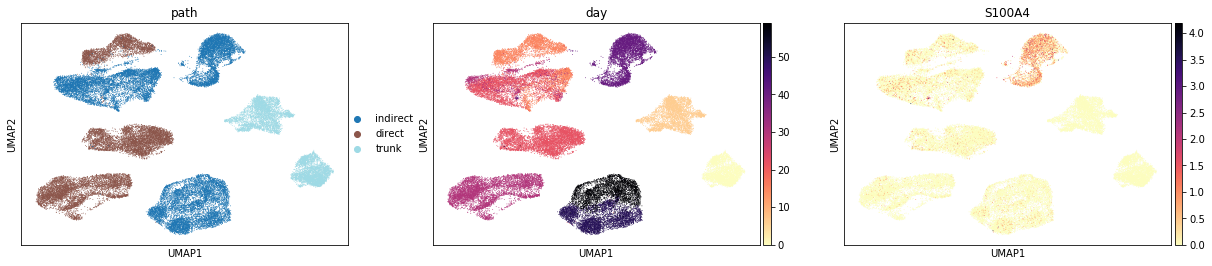

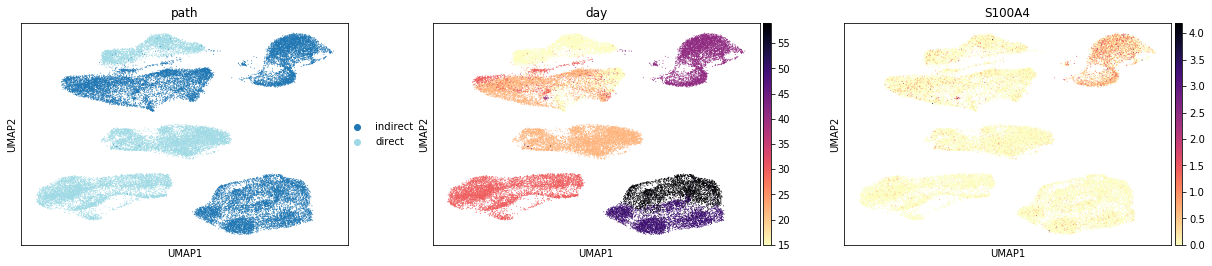

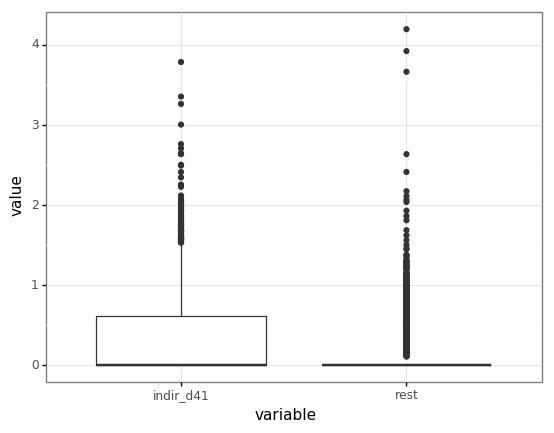

<ggplot: (8750905044912)>
querying 1-1...done.
Finished.
0:  S100A4 
 The protein encoded by this gene is a member of the S100 family of proteins containing 2 EF-hand calcium-binding motifs. S100 proteins are localized in the cytoplasm and/or nucleus of a wide range of cells, and involved in the regulation of a number of cellular processes such as cell cycle progression and differentiation. S100 genes include at least 13 members which are located as a cluster on chromosome 1q21. This protein may function in motility, invasion, and tubulin polymerization. Chromosomal rearrangements and altered expression of this gene have been implicated in tumor metastasis. Multiple alternatively spliced variants, encoding the same protein, have been identified. [provided by RefSeq, Jul 2008].


In [11]:
gene = 'S100A4'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')
sc.pl.umap(adata_all[adata_all.obs.path != 'trunk'], color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_indir_d41_df[gene].values,
                        'variable':'indir_d41'
                       }).append(pd.DataFrame({'value':adata_rest_df[gene].values,
                                               'variable':'rest'
                                              }))

print(ggplot(plot_df)
     + theme_bw()
     + geom_boxplot(aes('variable','value'))
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

# Correlation to fetal data

In [12]:
# create module to ingest primary fet/neo data for comparison
## read in adata with fetal melanocytes = adata_subset2
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
for file in ['adata_subset2']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

adata_subset2.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset2.obs.age]
adata_subset2.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset2.obs.general_location]
adata_subset2.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(adata_subset2.obs.dev_stage, adata_subset2.obs.subtypes)]


In [13]:
# bulk-ize terminal direct and indirect...spearman correlation to bulkized fetal
genes = list(set(adata_subset2.var_names) & set(adata_all.var_names))
input_adata = adata_subset2

for i in list(set(adata_subset2.obs.dev_subtype)):
    print(i)
    input_adata = adata_subset2[adata_subset2.obs.dev_subtype == i]

    cat, adata_subset2_df = prepare_dataframe(input_adata,
                                             genes,
                                            'patient',
                                             use_raw = True)
    adata_subset2_vec = adata_subset2_df.mean().values

    cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                             genes,
                                            'path',
                                             use_raw = True)
    adata_dir_d30_vec = adata_dir_d30_df.mean().values
    stat, pval = stats.spearmanr(adata_subset2_vec, adata_dir_d30_vec)
    print('direct', stat, pval)

    cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                             genes,
                                            'path',
                                             use_raw = True)
    adata_indir_d50_59_vec = adata_indir_d50_59_df.mean().values
    stat, pval = stats.spearmanr(adata_subset2_vec, adata_indir_d50_59_vec)
    print('indirect', stat, pval, '\n')


adt_acral
direct 0.6250045966653603 1.9464478978622888e-264
indirect 0.6327873010618701 5.174704986286764e-273 

adt_cutaneous
direct 0.6385277179826385 1.6957600082584674e-279
indirect 0.6522236330636108 1.530492007258205e-295 

fet_acral
direct 0.7027344352644193 0.0
indirect 0.7209836383966651 0.0 

fet_cutaneous
direct 0.707975708363957 0.0
indirect 0.7248994894821417 0.0 

neo_foreskin
direct 0.705877087421566 0.0
indirect 0.7134769949801489 0.0 



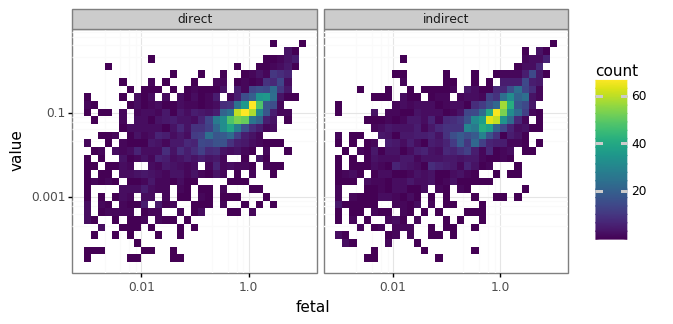

<ggplot: (8750905200988)>


In [15]:
bulkize_df = pd.DataFrame({'fetal':adata_subset2_vec, 
                          'direct':adata_dir_d30_vec,
                          'indirect':adata_indir_d50_59_vec})
bulkize_df = pd.melt(bulkize_df, id_vars='fetal')

print(ggplot(bulkize_df)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_bin2d(aes('fetal','value'))
      + facet_wrap('~variable')
      + scale_x_log10()
      + scale_y_log10()
     )


In [ ]:
# determine genes genes with lowest residuals and largest 

# Deprecated

In [ ]:
# wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
# %reload_ext autoreload
# %autoreload 2
# from scanpy_helpers import *
# print ('scanpy version: {}'.format(sc.__version__))
# warnings.filterwarnings('ignore')
# %matplotlib inline

# # path = 'dir'
# path = 'indir'

# pre_adata = pd.read_csv(f's3://darmanis-group/singlecell_meldiff/objects_and_data/{path}_all_COI_rawdata.csv', 
#                       index_col=[0])
# pre_adata.index.name = 'gene_name'

# meta_data = pd.read_csv(f's3://darmanis-group/singlecell_meldiff/objects_and_data/{path}_all_COI_metadata.csv', 
#                       index_col=[0])
# meta_data.index.name = 'cell_name'
             
# raw_adata = create_adata(pre_adata)
# raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
# sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo'], inplace=True)
# anno_dict = {'nGene':'nGene',
#              'nUMI':'nUMI',
#              'sample':'sample'
#             }
# append_anno(raw_adata, meta_data, anno_dict)
# technical_filters(raw_adata, min_genes=0,min_counts=0,min_cells=0)
# raw_adata = remove_ercc(raw_adata)
# raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

In [ ]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=30)
umap_adata(full_adata, res=0.25)

In [ ]:
sc.pl.umap(full_adata, color = ['sample','pct_counts_ribo','n_genes'], cmap = 'nipy_spectral', ncols = 2)


In [ ]:
# classify in raw adata
input_adata = full_adata

MEL_int = [0,1,3,4]
KRT_int = [x for x in range(len(input_adata.obs['louvain'].cat.categories)) if x not in MEL_int]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}
    
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_1')

In [ ]:
# MEL only

feature_dict = {'class_1':['MEL']}
adata_subset1 = subset_adata_v3(raw_adata,feature_dict)
adata_subset1 = process_adata(adata_subset1)
pca_adata(adata_subset1, num_pcs=30)
umap_adata(adata_subset1, res=0.15)

In [ ]:
# initial PC coordinates
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(adata_subset1.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
#     print(len(set(omit_names)))
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=5

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]
    filtered = df[bool_idx]
#     print('Filtered cells: ', len(df)-len(filtered))
    
    omit_names = omit_names + adata_subset1.obs[[not x for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata = adata_subset1
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# outliers on all-cells projection
input_adata = adata_subset1

type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')

sc.pl.umap(full_adata, color=['outliers'])

In [ ]:
# classify in raw adata
input_adata = adata_subset1

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
adata_subset2 = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(adata_subset2)
pca_adata(adata_subset2, num_pcs=10)
umap_adata(adata_subset2, res=0.35)

In [ ]:
# calculate txn noise
input_adata = adata_subset2
groupby = ['patient','anatomical_location']
features_df = (input_adata.obs.loc[:,groupby]
               .drop_duplicates()
               .reset_index()
               .drop('index', axis = 1))

noise_df = pd.DataFrame()
for row in range(len(features_df)):
    feature_slice = pd.DataFrame(features_df.iloc[row,:]).T
    filtered_adata = input_adata
    noise_group = []
    for col in feature_slice.columns:
        feature_match = feature_slice[col].values[0]
        filtered_adata = filtered_adata[filtered_adata.obs[col] == feature_match]
        noise_group.append(feature_match)

    cell_list = filtered_adata.obs.index.tolist()
    noise_slice = txn_noise_spearman(cell_list, pre_adata)
    noise_slice['noise_group'] = '_'.join(noise_group)
    noise_df = noise_df.append(noise_slice)

# update adata
ordered_noise = pd.merge(pd.DataFrame({'cell':adata_subset2.obs.index}), noise_df, 'left', 'cell')
adata_subset2.obs['agg_noise'] = ordered_noise.noise.values
adata_subset2.obs['noise_group'] = ordered_noise.noise_group.values
    

In [ ]:
# krt only re-cluster
feature_dict = {'class_1':['KRT']}
adata_subset1_KRT = subset_adata_v3(raw_adata,feature_dict)
adata_subset1_KRT = process_adata(adata_subset1_KRT)
pca_adata(adata_subset1_KRT, num_pcs=10)
umap_adata(adata_subset1_KRT, res=0.2)

In [ ]:
# pickle adatas
for objname in ['full_adata','adata_subset1','adata_subset2','pre_adata','adata_subset1_KRT']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))